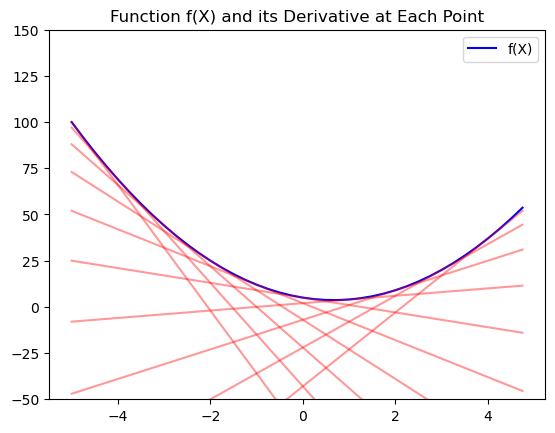

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
def f(x):
    return 3 * x ** 2 - 4 * x + 5

def df(x):
    return 6 * x - 4

Xs = np.arange(-5.0, 5.0, 0.25)

Ys = f(Xs)
Dys = df(Xs)

plt.plot(Xs, Ys, color='blue', label='f(X)')

for i in range(0, len(Xs), 4):
    tangent_line = Dys[i] * (Xs - Xs[i]) + Ys[i]
    plt.plot(Xs, tangent_line, color='red', alpha=0.4)

plt.ylim(-50, 150)

plt.legend()
plt.title("Function f(X) and its Derivative at Each Point")
plt.show()


In [2]:
class Value :
    def __init__(self, data, _children = () , _op = '' , label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.grad= 0.0
        self._backward = lambda : None
        self.label = label

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __repr__(self):  # needed so that our object value is more readable
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other , Value) else Value(other)
        out = Value(self.data + other.data , (self , other) , '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other , Value) else Value(other)
        out = Value(self.data * other.data , (self , other) , '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self , other):
        assert isinstance(other, (int, float)) , "only supporting int/float powers for now"
        out = Value(self.data**other , (self,) , f'**{other}')

        def _backward():
            self.grad += (other *  self.data ** (other -1)) * out.grad
        out._backward = _backward
        return out

    def __truediv__ (self, other):
        return self * other**-1

    def __radd__(self, other): # other + self
        return self + other

    def __rmul__(self, other):
        return self * other

    def exp(self):
        x = self.data
        out = Value(math.exp(x) , (self, ) , 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1)/(math.exp(2*x)+1)
        out = Value(t, (self, ) , 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

# a = Value(2.0 , label='a')
# b = Value(-3.0 , label='b')
# c = Value(10.0 , label='c')
# print(a + b) # internally called as print(a.__add__(b))
# print(a * b) # internally called as print(a.__mul__(b))
# e = a*b ; e.label = 'e'
# print(a*b + c) # internally called as print (a.__mul__(b)).__add__(c)
# d = e + c ; d.label = 'd'
# f = Value(-2.0 , label='f')
# L = d*f; L.label = 'L'
# L

In [3]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()

    def build(v):
        #print("Building node: {}".format(v.data))
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                #print("Child node: {}".format(child.data))
                #print("New edge: {} to {}".format(child.data, v.data))
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = Left to right
    #print("Root is: {}".format(root.data))

    nodes, edges = trace(root)

    for n in nodes:
        #print("Node is: {}".format(n.data))
        uid = str(id(n))
        #print("UID is: {}".format(uid))

        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data , n.grad), shape='record')

        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


In [4]:
draw_dot(L)

NameError: name 'L' is not defined

In [5]:
import math
x1 = Value(2.0 , label='x1')
x2 = Value(0.0 , label='x2')

w1 = Value(-3.0 , label = 'w1')
w2 = Value(1.0 , label = 'w2')

b = Value(6.8813735870195432 , label = 'b')
x1w1 = x1 * w1 ; x1w1.label = 'x1*w1'
x2w2 = x2 * w2 ; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh() ; o.label = 'o'
o.backward()

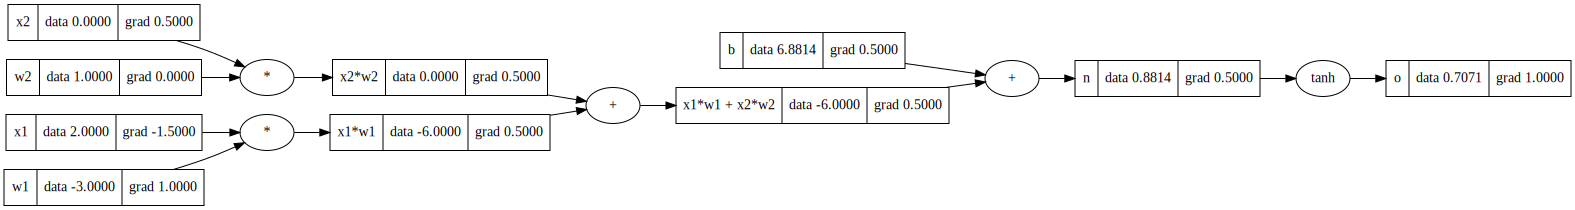

In [6]:
draw_dot(o)

In [7]:
o.backward()

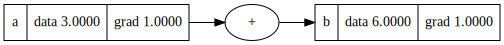

In [8]:
a = Value(3.0 , label = 'a')
b = a + a ;  b.label = 'b'
b.backward()
draw_dot(b)

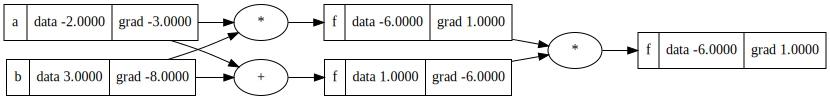

In [47]:
# important bug where gradients should accumulate when same value is used again
a = Value(-2.0 , label = 'a')
b = Value(3.0, label = 'b')
d = a * b ; d.label = 'f'
e = a + b ; e.label = 'f'
f = d * e ; f.label = 'f'

f.backward()
draw_dot(f)

In [48]:
# can't simply add any other type, we need to fix this
a = Value(1.0)
a + 1

Value(data=2.0)

In [49]:
# can't simply mul any other type, we need to fix this
a = Value(1.0)
a * 2

Value(data=2.0)

In [50]:
2 * a

Value(data=2.0)

In [51]:
a = Value(2.0)
b = Value(4.0)
a/b

Value(data=0.5)

In [52]:
a - b

Value(data=-2.0)

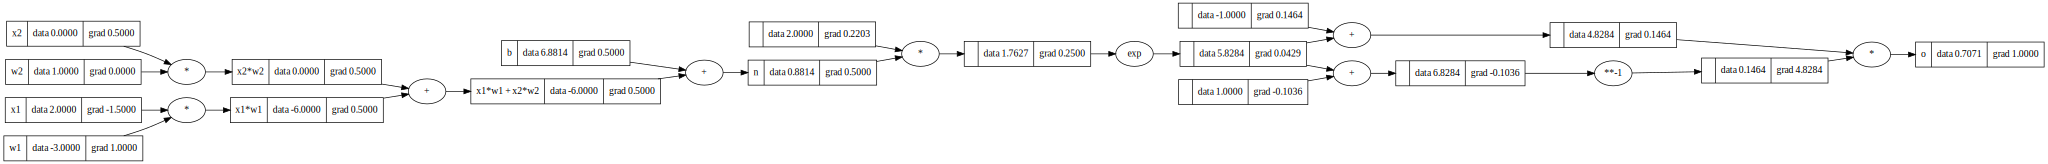

In [53]:
x1 = Value(2.0 , label='x1')
x2 = Value(0.0 , label='x2')

w1 = Value(-3.0 , label = 'w1')
w2 = Value(1.0 , label = 'w2')

b = Value(6.8813735870195432 , label = 'b')
x1w1 = x1 * w1 ; x1w1.label = 'x1*w1'
x2w2 = x2 * w2 ; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ____
e = (2*n).exp()
o = (e - 1)/(e + 1)
# ____
o.label = 'o'
o.backward()
draw_dot(o)

In [54]:
import tensorflow as tf

In [55]:
x1 = tf.Variable(2.0 , dtype = tf.float64)
x2 = tf.Variable(0.0 , dtype = tf.float64)
w1 = tf.Variable(-3.0 , dtype = tf.float64)
w2 = tf.Variable(1.0 , dtype = tf.float64)
b = tf.Variable(6.8813735870195432, dtype=tf.float64)

with tf.GradientTape() as tape :
    n = x1*w1 + x2*w2 + b
    o = tf.tanh(n)

print(o.numpy())

grads = tape.gradient(o , [x1 , x2 , w1 , w2, b])

print('---')
print('x2', grads[1].numpy())
print('w2', grads[3].numpy())
print('x1', grads[0].numpy())
print('w1', grads[2].numpy())
print('b', grads[4].numpy())

0.7071067811865476
---
x2 0.49999999999999994
w2 0.0
x1 -1.4999999999999998
w1 0.9999999999999999
b 0.49999999999999994


2024-08-22 23:41:14.830186: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-08-22 23:41:14.830217: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-08-22 23:41:14.830224: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-08-22 23:41:14.830392: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-22 23:41:14.830440: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [56]:
o.numpy()

0.7071067811865476

In [57]:
o

<tf.Tensor: shape=(), dtype=float64, numpy=0.7071067811865476>

In [58]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin , nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self , x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params

class MLP :
    def __init__(self , nin , nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i] , sz[i+1]) for i in range(len(nouts))]

    def __call__(self , x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [59]:
x = [2.0 , 3.0 , -1.0]
n = MLP(3 ,[4,4,1])
n(x)

Value(data=0.5480885938983218)

In [298]:
len(n.parameters())

41

In [299]:
xs = [[2.0 , 3.0 , -1.0],[3.0 , -1.0 , 0.5] , [0.5 , 1.0 , 1.0] , [1.0 , 1,0 , -1.0]]
ys = [1.0 , -1.0 , -1.0 , 1.0]

In [300]:
for k in range(10000):
    ypred= [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout  in zip(ys , ypred)])

    for p in n.parameters():
        p.grad = 0.0

    loss.backward()

    for p in n.parameters():
        p.data += -0.05 * p.grad

    #print(k , loss.data)

In [303]:
#draw_dot(loss)

ypred

[Value(data=0.9993636544442748),
 Value(data=-0.9982216624795537),
 Value(data=-0.9955996721320164),
 Value(data=0.995659210463113)]

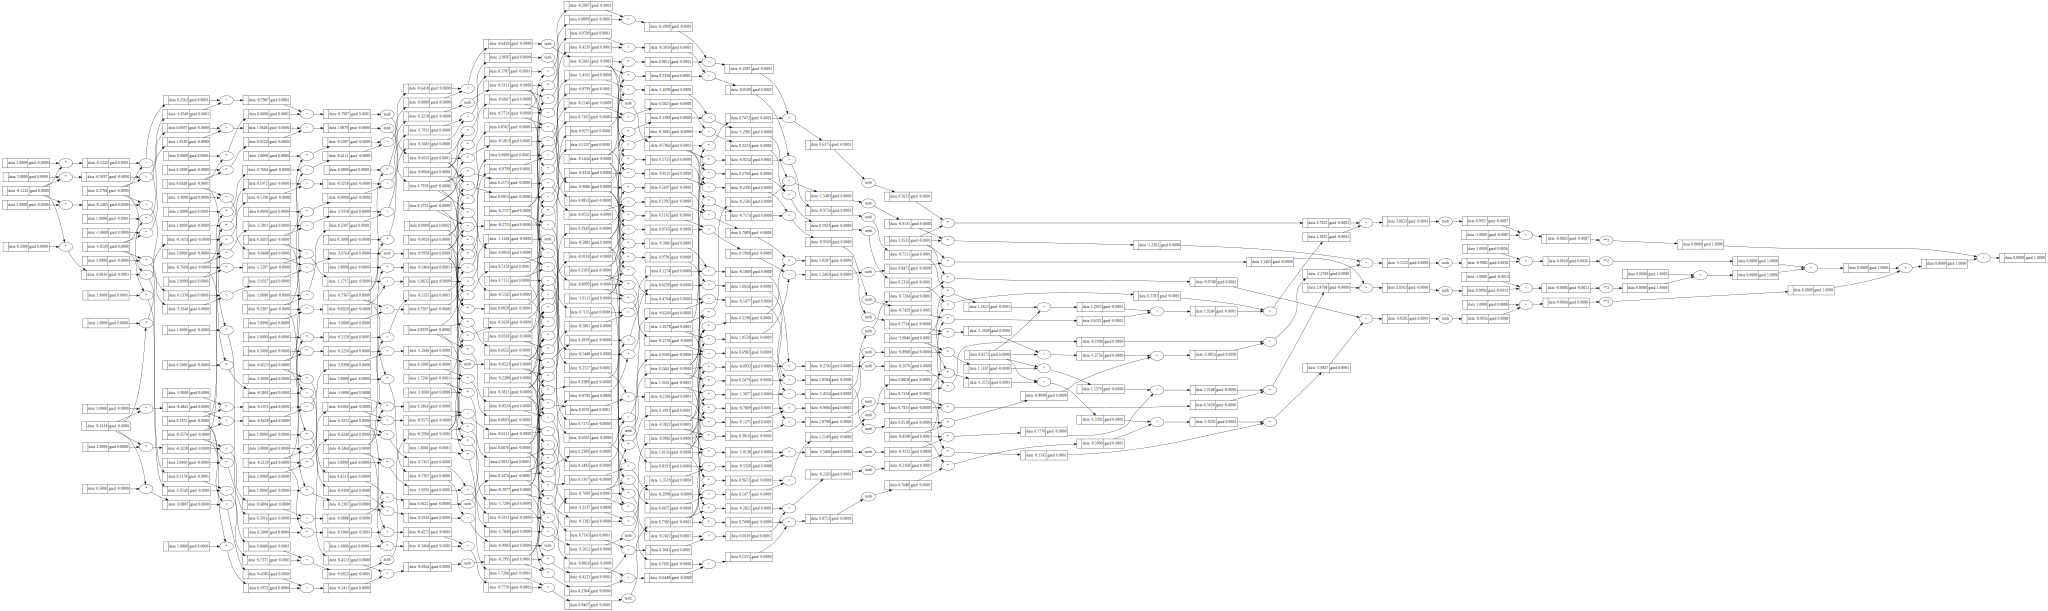

In [302]:
draw_dot(loss)

In [275]:
n.layers[0].neurons[0].w[0].data

0.8534312921141928

In [276]:
n.layers[0].neurons[0].w[0].grad

-2.6324604615294355e-05